In [2]:
import scipy                        
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy
import pandas
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import tensorflow
import ee
import json
from collections import OrderedDict
import time
import math
import csv

In [3]:
ee.Initialize()

In [31]:
inputImage = ee.Image('users/ccrs1fy2020/Test4')

In [32]:
inputImage_bands = ee.List(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'B13', 'LAI'])

### Vegetation Indices Sources

1. https://www.hindawi.com/journals/js/2017/1353691/tab1/
2. https://www.hiphen-plant.com/blog/vegetation-indices/
3. https://gisgeography.com/sentinel-2-bands-combinations/

In [33]:
input_VI_definition = ee.List(["GI      = b('B3')/b('B4')",
                              "RVI3    = b('B4')/b('B6')",
                              "SR3     = b('B5')/b('B4')",
                              "GM1     = b('B6')/b('B3')",
                              "GM2     = b('B6')/b('B5')",
                              "SR2     = b('B7')/b('B3')",
                              "PSSR    = b('B7')/b('B4')",
                              "SGI     = b('B8A')/b('B4')",
                              "MSI     = b('B11')/b('B7')",
                              "II      = b('B11')/b('B12')",
                              "GVI     = (b('B8A')/b('B3'))-1",
                              "PSRI    = (b('B4')-b('B3'))/b('B6')",
                              "NDVI3   = ((b('B8A')-b('B4'))/(b('B8A')))+b('B4')",
                              "SR5     = 1/b('B5')",
                              "SR6     = b('B4')/(b('B3')*b('B5'))",
                              "SR7     = b('B8A')/(b('B3')*b('B5'))",
                              "IPVI    = b('B7')/(b('B7')+b('B4'))",
                              "ARI     = (1/b('B3'))-(1/b('B5'))",
                              "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                              "NDVI    = (b('B8A')-b('B4'))/(b('B8A')+b('B4'))",
                              "GNDVI   = (b('B8A')-b('B3'))/(b('B8A')+b('B3'))",
                              "NDWI    = (b('B8A')-b('B11'))/(b('B8A')+b('B11'))",
                              "NDREVI  = (b('B8A')-b('B5'))/(b('B8A')+b('B5'))",
                              "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                              "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                              "NDI2    = (b('B8A')-b('B5'))/(b('B8A')-b('B4'))",
                              "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                              "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                              "NMDI    = (b('B8A')-(b('B11')-b('B12')))/(b('B8A')+(b('B11')-b('B12')))",
                              "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                              "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8A'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                              "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                              "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                              "EVI     = 2.5*((b('B8A')-b('B4'))/(b('B8A')+6*b('B4')-7.5*b('B3')+1))",
                              "EVI2    = 2.5*((b('B8A')-b('B4'))/(b('B8A')+2.4*b('B4')+1))",
                              "RDVI    = (b('B8A')-b('B4'))/((b('B8A')+b('B4'))**0.5)",
                              "MSR     = ((b('B8A')/b('B4'))-1)/((b('B8A')/b('B4'))**0.5+1)",
                              "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
                              "MSAVI2  = 0.5*(2*b('B8A')+1-((2*b('B8A')+1)**2-8*(b('B8A')-b('B4')))**0.5)",
                              "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
                              "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
                              "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                              "NLI     = ((b('B8A')**2)-b('B4'))/((b('B8A')**2)+b('B4'))"])

In [34]:
def format_image(image, image_bands, response_band, VI_definition):
    image = ee.Image(image)
    image_bands = ee.List(image_bands)
    response_band = ee.String(response_band)
    VI_definition = ee.List(VI_definition)
    
    # image_bands specifices a list of the names of the bands used in defining the expressions for VIs in VI_definition
    image = image.rename(image_bands).toDouble()
    
    # Generate an imageCollection from a list of expressions defining a set of Vegetation Indices using the bands available in the image
    VIimageCollection = ee.ImageCollection(VI_definition.map(lambda expr: image.expression(expr)))
    VIimage = VIimageCollection.toBands().regexpRename("[0-9]+_", "")
    
    # Reordering the bands in the image so the response band is the last band in the image
    feature_bands = image_bands.remove(response_band)
    return image.select(feature_bands).addBands(VIimage).addBands(image.select(response_band))

In [35]:
inputImage = format_image(inputImage, inputImage_bands, "LAI", input_VI_definition)

In [36]:
def get_num_pixels(image):
    # Retrieve the dimensions of the image from the metadata of the first band
    image_dimensions = ee.List(image.getInfo()["bands"][0]["dimensions"])
    image_height = image_dimensions.getNumber(0)
    image_width = image_dimensions.getNumber(1)
    image_pixels = image_height.multiply(image_width)
    
    return image_pixels

In [37]:
num_input_pixels = get_num_pixels(inputImage)

In [38]:
def scale_image(image, response_band):
    image = ee.Image(image)
    response_band = ee.String(response_band)
    image_pixels = ee.Number(get_num_pixels(image))
    
    # Setting up lists containing the input/feature bands in the image
    bandList = image.bandNames()
    featureList = bandList.remove(response_band)
    num_bands = bandList.length()
    num_features = featureList.length()
    
    # We will be using the reduceRegion() function on images from Earth Engine, 
    # which will process up to a specified number of pixels from the image to generate the outputs of the reducer
    max_pixels = image_pixels.min(10000000)
    best_effort = ee.Algorithms.If(image_pixels.gt(max_pixels), True, False)
    
    # Initial centering of all of the bands in the image for LARs, we will centre the sampled data later as well as reduceRegion() is not precise enough
    meanImage = image.subtract(image.reduceRegion(reducer=ee.Reducer.mean(), bestEffort=best_effort, maxPixels=max_pixels).toImage(bandList))
    
    # Separating the image into features (X) and response (y) as we need to standardize the input features
    X = meanImage.select(featureList)
    y = meanImage.select(response_band)
    
    # Standardizing the input features
    X = X.divide(X.reduceRegion(reducer=ee.Reducer.stdDev(), bestEffort=best_effort, maxPixels=max_pixels).toImage(featureList))
    
    return X.addBands(y)

In [39]:
scaledImage = scale_image(inputImage, "LAI")

In [40]:
def ee_LARS(image, response_band, num_nonzero_coefficients, num_samples, image_pixels):
    image = ee.Image(image)
    response_band = ee.String(response_band)
    num_nonzero_coefficients = ee.Number(num_nonzero_coefficients)
    num_samples = ee.Number(num_samples)
    image_pixels = ee.Number(image_pixels)
    
    bandList = image.bandNames()
    featureList = bandList.remove(response_band)
    
    inputCollection = image.sample(numPixels=num_samples.min(image_pixels))
    
    n = inputCollection.size()
    m = featureList.length()
    
    inputs = ee.Dictionary.fromLists(bandList, bandList.map(lambda feature: inputCollection.aggregate_array(feature)))
    
    input_means = ee.Dictionary.fromLists(bandList, bandList.map(lambda feature: inputCollection.aggregate_mean(feature)))
    def centre_inputs(key, value):
        key_mean = input_means.getNumber(key)
        return ee.List(value).map(lambda sample: ee.Number(sample).subtract(key_mean))
    inputs = inputs.map(centre_inputs)
    y = inputs.toArray([response_band]).reshape([-1,1])
    
    inputs = inputs.select(featureList)
    input_norms = inputs.map(lambda key, value: ee.Number(ee.List(value).map(lambda sample: ee.Number(sample).pow(2)).reduce(ee.Reducer.sum())).pow(0.5))
    def norm_inputs(key, value):
        key_norm = input_norms.getNumber(key)
        return ee.List(value).map(lambda sample: ee.Number(sample).divide(key_norm))
    inputs = inputs.map(norm_inputs)
    X = inputs.toArray(featureList).transpose()
    
    
    initial_prediction = ee.Array(ee.List.repeat([0], n))
    c = X.transpose().matrixMultiply(y.subtract(initial_prediction))
    c_abs = c.abs()
    C_maxLoc = c_abs.project([0]).argmax()
    add_feature = C_maxLoc.getNumber(0)
    A = ee.List([add_feature])
    
    initial_inputs = ee.Dictionary({'prediction': initial_prediction, 'A': A})
    
    def LARs_regression(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        
        A = ee.List(inputs.get('A'))
        A_list = ee.Array(ee.List.sequence(0, m.subtract(1)).map(lambda index: A.contains(index)).replaceAll(False, 0).replaceAll(True, 1)).reshape([-1,1])
        
        prediction = inputs.getArray('prediction')
        c = X.transpose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())
        
        s_A = c.divide(c_abs).mask(A_list)
        X_A = X.mask(A_list.transpose())
        G_Ai = X_A.transpose().matrixMultiply(X_A).matrixInverse()
        G1 = G_Ai.matrixMultiply(s_A)
        A_A = s_A.project([0]).dotProduct(G1.project([0])).pow(-0.5)
        w_A = G1.multiply(A_A)
        u_A = X_A.matrixMultiply(w_A)
        a = X.transpose().matrixMultiply(u_A)
        
        a = a.project([0])
        c = c.project([0])
        def compute_gammaArray(index_j):
            minus_j = C_max.subtract(c.get([index_j])).divide(A_A.subtract(a.get([index_j])))
            plus_j = C_max.add(c.get([index_j])).divide(A_A.add(a.get([index_j])))
            
            return ee.List([minus_j, plus_j]).filter(ee.Filter.gte('item', 0)).reduce(ee.Reducer.min())
        
        A_c = ee.List.sequence(0, m.subtract(1)).removeAll(A)
        gammaArray = A_c.map(compute_gammaArray)
        gamma = gammaArray.reduce(ee.Reducer.min())
        min_location = gammaArray.indexOf(gamma)
        add_feature = A_c.getNumber(min_location)
        A = A.add(add_feature)
        
        prediction = prediction.add(u_A.multiply(gamma))
        
        return ee.Dictionary({'prediction': prediction, 'A': A})
    
    def LARs_final_iteration(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        A = ee.List(inputs.get('A'))
        
        prediction = inputs.getArray('prediction')
        c = X.transpose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())        
        
        s_A = c.divide(c_abs)
        G_Ai = X.transpose().matrixMultiply(X).matrixInverse()
        G1 = G_Ai.matrixMultiply(s_A)
        A_A = s_A.project([0]).dotProduct(G1.project([0])).pow(-0.5)
        w_A = G1.multiply(A_A)
        u_A = X.matrixMultiply(w_A)
        
        gamma = C_max.divide(A_A)
        prediction = prediction.add(u_A.multiply(gamma))
        
        return ee.Dictionary({'prediction': prediction, 'A': A})
    
    
    iterations = ee.List.sequence(1, m.subtract(1).min(num_nonzero_coefficients))
    penultimate_outputs = iterations.iterate(LARs_regression, initial_inputs)
    final_outputs = ee.Dictionary(ee.Algorithms.If(num_nonzero_coefficients.gte(m), LARs_final_iteration(m, penultimate_outputs), penultimate_outputs))
    
    final_prediction = final_outputs.getArray('prediction')
    A = ee.List(final_outputs.get('A'))
    feature_path = A.slice(0, num_nonzero_coefficients).map(lambda index: featureList.getString(index))
    
#     coefficients = X.matrixSolve(final_prediction).project([0]).toList().map(lambda num: ee.Algorithms.If(ee.Number(num).abs().lt(0.001), 0, num))
#     print('Coefficients')
#     coeff = ee.Dictionary.fromLists(featureList, coefficients).getInfo()
#     ordered_coeff = OrderedDict()
#     var_path = feature_path.cat(featureList.removeAll(feature_path)).getInfo()
#     for key in var_path:
#         ordered_coeff[key] = coeff[key]
#     print(json.dumps(ordered_coeff, indent=1))
    
    return feature_path #.getInfo()

In [41]:
select_features = ee_LARS(scaledImage, "LAI", 5, 50000, num_input_pixels)

In [42]:
def trim_data(image, selected_features, response_band, num_samples, num_partitions):
    image = ee.Image(image)
    selected_features = ee.List(selected_features)
    response_band = ee.String(response_band)
    num_samples = ee.Number(num_samples)
    num_partitions = ee.Number(num_partitions)
    
    percentiles = ee.List.sequence(0, 100, ee.Number(100).divide(num_partitions))
    percentile_names = percentiles.map(lambda num: ee.Number(num).round().toInt().format("p%s"))
    
    image_pixels = ee.Number(get_num_pixels(image))
    inputsCollection = image.select(selected_features.add(response_band)).sample(numPixels=num_samples.min(image_pixels))
    
    response_percentiles = inputsCollection.reduceColumns(ee.Reducer.percentile(percentiles=percentiles, outputNames=percentile_names, maxRaw=inputsCollection.size()), [response_band])
    response_partitions = response_percentiles.values(percentile_names.remove('p100')).zip(response_percentiles.values(percentile_names.remove('p0')))
    
    def partition_data(partition_range):
        partition_range = ee.List(partition_range)
        return inputsCollection.filter(ee.Filter.rangeContains(response_band, partition_range.getNumber(0), partition_range.getNumber(1)))
    
    partitioned_data = response_partitions.map(partition_data)
    
    def trim_partitions(partition):
        partition = ee.FeatureCollection(partition)
        feature_trimming_bounds = selected_features.map(lambda feature: ee.List([feature]).cat(partition.reduceColumns(ee.Reducer.percentile([5, 95]), [feature]).values(['p5','p95'])))
        def trimmer(current_feature, collection):
            current_feature = ee.List(current_feature)
            collection = ee.FeatureCollection(collection)
            return collection.filter(ee.Filter.rangeContains(current_feature.getString(0), current_feature.getNumber(1), current_feature.getNumber(2)))
        return feature_trimming_bounds.iterate(trimmer, partition)
    
    trimmed_partitions = partitioned_data.map(trim_partitions)
    trimmed_data = ee.FeatureCollection(trimmed_partitions).flatten()
    
    return trimmed_data

In [43]:
exportData = ee.batch.Export.table.toDrive(collection=trim_data(image=inputImage, selected_features=select_features, response_band="LAI", num_samples=50000, num_partitions=10),
                                           description="image_data_samples",
                                           folder="Colab Notebooks",
                                           fileFormat="CSV")

In [44]:
exportData.start()

In [ ]:
prev_task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
while exportData.active():
    task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(exportData.id)[0]["state"])

In [46]:
ee.batch.Task.list()

[<Task EXPORT_FEATURES: image_data_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: image_data_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: image_data_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: image_data_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: image_data_samples (FAILED)>,
 <Task EXPORT_FEATURES: image_data_samples (FAILED)>,
 <Task EXPORT_FEATURES: image_data_samples (FAILED)>,
 <Task EXPORT_FEATURES: image_data_samples (FAILED)>,
 <Task EXPORT_FEATURES: trimmed_image_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: untrimmed_image_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: trimmed_image_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: untrimmed_image_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: trimmed_image_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: untrimmed_image_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: trimmed_image_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: untrimmed_image_samples (COMPLETED)>,
 <Task EXPORT_FEATURES: Test_4_image_sample_export (COMPLETED)>]

In [4]:
trimmed_data = pandas.read_csv('image_data_samples.csv')
X = trimmed_data.drop(labels=['LAI', 'system:index', '.geo'], axis=1)
y = trimmed_data.LAI

In [5]:
X = pandas.DataFrame(sklearn.preprocessing.scale(X))

In [6]:
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(5, input_shape=[len(X.keys())]),
    tensorflow.keras.layers.Dense(4, activation="softsign"),
    tensorflow.keras.layers.Dense(3, activation="softsign"),
    tensorflow.keras.layers.Dense(2, activation="softsign"),
    tensorflow.keras.layers.Dense(1)
])
LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

In [7]:
LAI_model.fit(x = X.to_numpy(), y = y.to_numpy(), epochs = 100)

Train on 36572 samples
Epoch 1/100
36572/36572 [==============================] - 2s 48us/sample - loss: 0.1917 - mse: 0.1917 - mae: 0.2974
Epoch 2/100
36572/36572 [==============================] - 1s 29us/sample - loss: 0.0574 - mse: 0.0574 - mae: 0.1793
Epoch 3/100
36572/36572 [==============================] - 1s 29us/sample - loss: 0.0458 - mse: 0.0458 - mae: 0.1621
Epoch 4/100
36572/36572 [==============================] - 1s 30us/sample - loss: 0.0420 - mse: 0.0420 - mae: 0.1558
Epoch 5/100
36572/36572 [==============================] - 1s 30us/sample - loss: 0.0406 - mse: 0.0406 - mae: 0.1532
Epoch 6/100
36572/36572 [==============================] - 1s 30us/sample - loss: 0.0391 - mse: 0.0391 - mae: 0.1502
Epoch 7/100
36572/36572 [==============================] - 1s 30us/sample - loss: 0.0371 - mse: 0.0371 - mae: 0.1460
Epoch 8/100
36572/36572 [==============================] - 1s 29us/sample - loss: 0.0359 - mse: 0.0359 - mae: 0.1433
Epoch 9/100
36572/36572 [================

In [313]:
LAI_predictions = pandas.Series(LAI_model.predict(X.to_numpy()).flatten())

In [314]:
xy_tf_LAI = numpy.vstack([y, LAI_predictions])

In [315]:
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

In [316]:
idx_tf_LAI = z_tf_LAI.argsort()
x_tf_LAI = y[idx_tf_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

In [317]:
rmse_tf_LAI = sklearn.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

Text(0.5, 1.0, 'LASSO LARS FAPAR - RMSE: 0.17261192083450266')

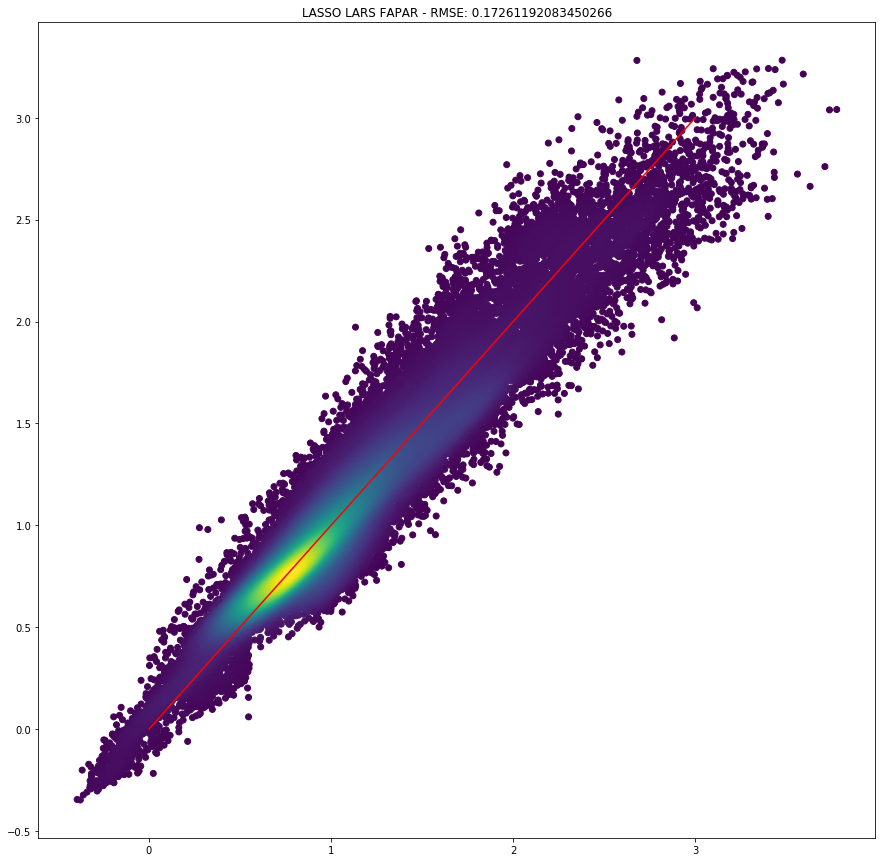

In [318]:
a_tf_LAI = numpy.linspace(0, 3, 1000)

fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax.plot(a_tf_LAI, a_tf_LAI, c='r')
ax.set_title('LASSO LARS FAPAR - RMSE: {}'.format(rmse_tf_LAI))

In [334]:
def elu(x):
    return x if x>=0 else (math.exp(x)-1)

In [335]:
def softplus(x):
    return math.log(math.exp(x)+1)

In [338]:
def softsign(x):
    return x/(abs(x)+1)

In [344]:
def relu(x):
    return max(x, 0.0)

In [347]:
def tanh(x):
    return (math.exp(2*x)-1)/(math.exp(2*x)+1)

In [354]:
def sigmoid(x):
    return 1/(1+math.exp(-x))

In [355]:
elu = numpy.vectorize(elu)
softplus = numpy.vectorize(softplus)
softsign = numpy.vectorize(softsign)
relu = numpy.vectorize(relu)
tanh = numpy.vectorize(tanh)
sigmoid = numpy.vectorize(sigmoid)

In [358]:
activation_functions = {"elu": elu, "softplus": softplus, "softsign": softsign, "relu": relu, "tanh": tanh, "sigmoid": sigmoid}

In [359]:
def apply_nnet(inputs, keras_model):
    
    for layer in keras_model.layers:
        layer_weights = layer.get_weights()
        node_weights = layer_weights[0]
        bias = layer_weights[1]
        
        inputs = inputs.dot(node_weights)+bias
        
        activation_function = layer.get_config()["activation"]
        if(activation_function != "linear"):
            activation_function = activation_functions[activation_function]
            
            inputs = activation_function(inputs)
            
    return inputs

In [371]:
row = 4802
inputs = X.iloc[row, :].to_numpy()
print(LAI_model.predict(inputs.reshape((-1,5)))[0][0])
print(apply_nnet(inputs, LAI_model)[0])

0.64478326
0.6447832819397781


In [426]:
def export_nnet(keras_model):
    nnet_data = []
    headers = []
    prevLayerSize = len(X.keys())
    
    for layer in keras_model.layers:
        layer_info = layer.get_config()
        num_nodes = layer_info["units"]
        activation_function = layer_info["activation"]
        layer_weights = layer.get_weights()[0]
        layer_bias = layer.get_weights()[1]
        
        headers = list(set(headers) | set([x for x in range((prevLayerSize+1)*num_nodes)]))
        prevLayerSize = num_nodes
        
        layer_data = [0, 0, num_nodes, activation_function] + layer_weights.flatten().tolist() + layer_bias.tolist()
        nnet_data.append(layer_data)
    
    nnet_data.insert(0, ["latitude", "longitude", "num_nodes", "activation"]+headers)
    return nnet_data

In [429]:
export_data = export_nnet(LAI_model)
with open('nnet.csv', 'w', newline='') as csvfile:
    nnet_writer = csv.writer(csvfile)
    for layerdata in export_data:
        nnet_writer.writerow(layerdata)

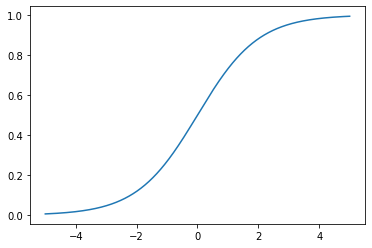

In [356]:
x = numpy.linspace(-5, 5, 1000)
plt.plot(x, sigmoid(x))

In [46]:
matlabData = sio.loadmat(file_name='data/s2_sl2p_weiss_or_prosail_inout.mat', variable_names=['Input', 'Output'])

In [47]:
                                                                # B1  443nm, Ultra blue, 60m res
                                                                # B2  490nm, blue, 10m res
B3 = pandas.DataFrame(matlabData['Input']['Rho_Toc'][0][0])[0]      # 560nm, green, 10m res
B4 = pandas.DataFrame(matlabData['Input']['Rho_Toc'][0][0])[1]      # 665nm, red, 10m res
B5 = pandas.DataFrame(matlabData['Input']['Rho_Toc'][0][0])[2]      # 705nm, VNIR, 20m res
B6 = pandas.DataFrame(matlabData['Input']['Rho_Toc'][0][0])[3]      # 740nm, VNIR, 20m res
B7 = pandas.DataFrame(matlabData['Input']['Rho_Toc'][0][0])[4]      # 783nm, VNIR, 20m res
                                                                # B8  842nm, VNIR, 10m res
B8A = pandas.DataFrame(matlabData['Input']['Rho_Toc'][0][0])[5]     # 865nm, VNIR, 20m res
                                                                # B9  940nm, SWIR, 60m res
                                                                # B10 1375nm, SWIR, 60m res
B11 = pandas.DataFrame(matlabData['Input']['Rho_Toc'][0][0])[6]     # 1610nm, SWIR, 20m res
B12 = pandas.DataFrame(matlabData['Input']['Rho_Toc'][0][0])[7]     # 2190nm, SWIR, 20m res

LAI = pandas.Series(data=matlabData['Output']['LAI'][0][0].flatten())
FAPAR = pandas.Series(data=matlabData['Output']['FAPAR'][0][0].flatten())
FCOVER = pandas.Series(data=matlabData['Output']['FCOVER'][0][0].flatten())

LAI_mean = LAI.mean()
FAPAR_mean = FAPAR.mean()
FCOVER_mean = FCOVER.mean()

In [48]:
RVI1    = B4/B8A
RVI2    = B4/B7
RVI3    = B4/B6
RVI4    = B4/B5
GM1     = B6/B3
GM2     = B6/B5
GI      = B3/B4
II      = B11/B12
MSI     = B11/B7
PSSR    = B7/B4
SGI     = B8A/B4
SR2     = B7/B3
SR3     = B5/B4
GVI     = (B8A/B3)-1
PSRI    = (B4-B3)/B6
NDVI3   = ((B8A-B4)/(B8A))+B4
SR5     = B4/(B5*B4)
SR6     = B4/(B3*B5)
SR7     = B8A/(B3*B5)
IPVI    = B7/(B7+B4)
ARI     = (1/B3)-(1/B5)
ARI2    = B7*((1/B3)-(1/B5))
NDVI    = (B8A-B4)/(B8A+B4)
GNDVI   = (B8A-B3)/(B8A+B3)
NDWI    = (B8A-B11)/(B8A+B11)
NDREVI  = (B8A-B5)/(B8A+B5)
NDGI    = (B3-B4)/(B3+B4)
NDI1    = (B7-B5)/(B7-B4)
NDI2    = (B8A-B5)/(B8A-B4)
RENDVI  = (B6-B5)/(B6+B5)
OSAVI   = (1.16*(B7-B4))/(B7+B4+0.61)
NMDI    = (B8A-(B11-B12))/(B8A+(B11-B12))
HI      = ((B3-B5)/(B3+B5))-0.5*B5
GVSP    = (-0.283*B3 - 0.66*B4 + 0.577*B6 + 0.388*B8A)/(0.433*B3 - 0.632*B4 + 0.586*B6 + 0.264*B8A)
MCARI   = ((B5-B4)-0.2*(B5-B3))*(B5/B4)
TCARI   = 3*((B5-B4)-0.2*(B5-B3)*(B5/B4))
EVI     = 2.5*((B8A-B4)/(B8A+6*B4-7.5*B3+1))
EVI2    = 2.5*((B8A-B4)/(B8A+2.4*B4+1))
RDVI    = (B8A-B4)/((B8A+B4)**0.5)
MSR     = ((B8A/B4)-1)/((B8A/B4)**0.5+1)
MSAVI   = 0.5*(2*B7+1-((2*B7+1)**2-8*(B7-B4))**0.5)
MSAVI2  = 0.5*(2*B8A+1-((2*B8A+1)**2-8*(B8A-B4))**0.5)
MCARI2  = (1.5*(2.5*(B7-B4)-1.3*(B7-B3)))/((((2*B7+1)**2)-(6*B7-5*(B4**0.5))-0.5)**0.5)
MTVI2   = (1.5*(1.2*(B7-B3)-2.5*(B4-B3)))/(((2*B7+1)**2-(6*B7-5*B4)-0.5)**0.5)
N       = (2*((B8A**2)-(B4**2))+1.5*B8A+0.5*B4)/(B8A+B4+0.5)
GEMI    = N*(1-0.25*N)-((B4-0.125)/(1-B4))
MSR2    = ((B7/B4)-1)/(((B7/B4)+1)**0.5)
NLI     = ((B8A**2)-B4)/((B8A**2)+B4)
TDVI    = (0.5+((B8A-B4)/(B8A+B4)))**0.5

add correlation matrix calculation, and single feature collection

In [49]:
outputCSV = pandas.concat([ B3, B4, B5, B6, B7, B8A, B11, B12,
                            RVI1, RVI2, RVI3, RVI4, GM1, GM2, GI, II, MSI,
                            PSSR, SGI, SR2, SR3, GVI, PSRI, NDVI3, SR5, SR6,
                            SR7, IPVI, ARI, ARI2, NDVI, GNDVI, NDWI, NDREVI, NDGI,
                            NDI1, NDI2, RENDVI, OSAVI, NMDI, HI, GVSP, MCARI,
                            TCARI, EVI, EVI2, RDVI, MSR, MSAVI, MSAVI2, MCARI2,
                            MTVI2, N, GEMI, MSR2, NLI, TDVI, LAI, FAPAR, FCOVER ], 
                            axis=1, join='outer')
outputCSV['latitude'] = 0
outputCSV['longitude'] = 0
outputCSV.columns =['B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12',
                    'RVI1', 'RVI2', 'RVI3', 'RVI4', 'GM1', 'GM2', 'GI', 'II', 'MSI',
                    'PSSR', 'SGI', 'SR2', 'SR3', 'GVI', 'PSRI', 'NDVI3', 'SR5', 'SR6',
                    'SR7', 'IPVI', 'ARI', 'ARI2', 'NDVI', 'GNDVI', 'NDWI', 'NDREVI', 'NDGI',
                    'NDI1', 'NDI2', 'RENDVI', 'OSAVI', 'NMDI', 'HI', 'GVSP', 'MCARI',
                    'TCARI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI', 'MSAVI2', 'MCARI2',
                    'MTVI2', 'N', 'GEMI', 'MSR2', 'NLI', 'TDVI', 'LAI', 'FAPAR', 'FCOVER', 
                    'latitude', 'longitude']
outputCSV

,B3,B4,B5,B6,B7,B8A,B11,B12,RVI1,RVI2,...,N,GEMI,MSR2,NLI,TDVI,LAI,FAPAR,FCOVER,latitude,longitude
0,0.048953,0.030271,0.073742,0.294630,0.419698,0.436037,0.121603,0.043615,0.069422,0.072125,...,1.084141,0.887987,3.336756,0.725310,1.170542,6.014594,0.870412,0.875424,0,0
1,0.053655,0.029552,0.074523,0.383288,0.566787,0.597187,0.180981,0.054689,0.049485,0.052139,...,1.439619,1.019848,4.046955,0.846956,1.185621,5.752335,0.957268,0.971936,0,0
2,0.075767,0.092849,0.144840,0.267414,0.306598,0.321708,0.254556,0.145838,0.288614,0.302837,...,0.785885,0.666923,1.109901,0.054225,1.025698,0.746137,0.386350,0.394260,0,0
3,0.071742,0.031115,0.094643,0.303518,0.383710,0.391068,0.118468,0.047038,0.079565,0.081091,...,0.982550,0.838099,3.103530,0.661880,1.163012,5.374681,0.819419,0.830017,0,0
4,0.100043,0.028230,0.130998,0.442701,0.560120,0.563746,0.182785,0.062757,0.050075,0.050399,...,1.367942,0.999707,4.127172,0.836842,1.185169,5.467322,0.899630,0.927706,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41467,0.091781,0.028950,0.124602,0.420813,0.528081,0.544847,0.122709,0.032790,0.053135,0.054822,...,1.325936,0.985322,3.930491,0.822286,1.182832,4.951841,0.922245,0.949148,0,0
41468,0.046467,0.034942,0.069040,0.229278,0.308859,0.321834,0.126807,0.071680,0.108572,0.113133,...,0.822777,0.746855,2.499143,0.495492,1.141982,4.453112,0.717015,0.714964,0,0
41469,0.045621,0.027923,0.067862,0.307144,0.445989,0.474847,0.162763,0.055750,0.058805,0.062610,...,1.172384,0.928628,3.634234,0.779614,1.178526,4.579922,0.861480,0.871602,0,0
41470,0.053039,0.037354,0.081990,0.340293,0.506438,0.528001,0.190817,0.076028,0.070745,0.073757,...,1.281693,0.962056,3.291311,0.763689,1.169555,5.502935,0.879030,0.882815,0,0


In [6]:
outputCSV.to_csv(path_or_buf=r'transformedFeatures.csv')

In [50]:
outputCSV.head(n=500).to_csv(path_or_buf=r'testFeatures.csv')

In [7]:
import ee
ee.Initialize()

In [25]:
def EE_LARS_Regression(assetName, features, response, maxSamples, n_nonzero):
        
    inputCSV = ee.FeatureCollection(assetName)
    inputCSV = inputCSV.toList(count=maxSamples)
    
    def extractBands(feature):
        feature = ee.Feature(feature)
        return feature.toArray(properties=features).toList()

    def extractVI(feature):
        feature = ee.Feature(feature)
        return feature.toArray(properties=[response]).toList()
    
    inputList = inputCSV.map(extractBands)
    outputList = inputCSV.map(extractVI)
    
    X = ee.Array(inputList)
    y = ee.Array(outputList)
    
    n = X.length().get([0])
    m = X.length().get([1])
    
    
    def centre(output):
        output = ee.Array(output)
        mean = output.reduce(ee.Reducer.mean(), [0]).get([0,0])
        return output.subtract(mean)
        
    def normalize(inputs):
        inputs = ee.Array(inputs)
        
        inputMeans = inputs.reduce(ee.Reducer.mean(), [0])
        inputMeans = inputMeans.repeat(0, n)
        inputs = inputs.subtract(inputMeans)
        inputs = inputs.pow(2).reduce(ee.Reducer.sum(), [0]).pow(-0.5).repeat(0,n).multiply(inputs)
        
        return inputs
    
    X = normalize(X)
    y = centre(y)
    
    def LARSregression(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        prediction = inputs.getArray('prediction')
        coeff_arr = inputs.getArray('coeff_arr')
    
        c = X.matrixTranspose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())

        maxLocs = c_abs.gte(C_max.subtract(0.00001))
        signs = c.divide(c_abs)

        signs_j = maxLocs.multiply(signs).matrixTranspose()
        signs_jc = signs_j.abs().subtract(1).multiply(-1)
        
        A = ee.List(ee.Array([ee.List.sequence(0, m.subtract(1))]).mask(signs_j).toList().get(0))
        A_c = ee.List(ee.Array([ee.List.sequence(0, m.subtract(1))]).mask(signs_jc).toList().get(0))

        signMatrix_j = signs_j.repeat(0, n)

        X_A = X.multiply(signMatrix_j).mask(signs_j)
        j = X_A.length().get([1])
        
        G_A = X_A.matrixTranspose().matrixMultiply(X_A)

        V1_A = ee.Array(ee.List.repeat([1], j))

        G_Ai = G_A.matrixInverse()

        A_A = V1_A.matrixTranspose().matrixMultiply(G_Ai).matrixMultiply(V1_A).get([0,0]).pow(-0.5)

        w_A = G_Ai.matrixMultiply(V1_A).multiply(A_A)

        u_A = X_A.matrixMultiply(w_A)

        a = X.matrixTranspose().matrixMultiply(u_A)

        def computeGammaRRay(index_j):
            minus_j = C_max.subtract(c.get([index_j, 0])).divide(A_A.subtract(a.get([index_j, 0])))
            plus_j = C_max.add(c.get([index_j, 0])).divide(A_A.add(a.get([index_j, 0])))

            gammaRRay = ee.Array([minus_j, plus_j])
            gammaRRay = gammaRRay.mask(gammaRRay.gte(0))
            gammaRRay = gammaRRay.multiply(-1)

            return gammaRRay.get(gammaRRay.argmax())

        gammaRRay = ee.Array([A_c.map(computeGammaRRay)])
        gamma = gammaRRay.get(gammaRRay.argmax()).multiply(-1)

        prediction = prediction.add(u_A.multiply(gamma))
        coefficients = X.matrixSolve(prediction)

        def setZero(num):
            num = ee.Number(num)
            return ee.Algorithms.If(num.abs().lt(0.0001), [0], [num])

        coefficients = ee.Array(ee.List(coefficients.matrixTranspose().toList().get(0)).map(setZero))

        coeff_arr = ee.Array.cat([coeff_arr, coefficients], axis=1)

        outputs = ee.Dictionary({'prediction':prediction, 'coeff_arr':coeff_arr})

        return outputs
    
    
    numIterations = ee.List.sequence(1, n_nonzero)
    prediction = ee.Array(ee.List.repeat([0], n))
    coeff_arr = ee.Array(ee.List.repeat([0], m))
    initial = ee.Dictionary({'prediction':prediction, 'coeff_arr':coeff_arr})

    finalOutputs = numIterations.iterate(LARSregression, initial)
    finalOutputs = ee.Dictionary(finalOutputs)
    
    finalPrediction = finalOutputs.getArray('prediction')
    finalPrediction = finalPrediction.getInfo()
    finalPrediction = numpy.asarray(finalPrediction)
    
    coeff_arr = finalOutputs.getArray('coeff_arr')
    coeff_arr = coeff_arr.getInfo()
    coeff_arr = numpy.asarray(coeff_arr)
    
    return coeff_arr, finalPrediction

In [28]:
LAI_coef, LAI_predicted = EE_LARS_Regression('users/ccrs2fy2020/transformedFeatures', 
                              [ 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12',
                                'RVI1', 'RVI2', 'RVI3', 'RVI4', 'GM1', 'GM2', 'GI', 'II', 'MSI',
                                'PSSR', 'SGI', 'SR2', 'SR3', 'GVI', 'PSRI', 'NDVI3', 'SR5', 'SR6',
                                'SR7', 'IPVI', 'ARI', 'ARI2', 'NDVI', 'GNDVI', 'NDWI', 'NDREVI', 'NDGI',
                                'NDI1', 'NDI2', 'RENDVI', 'OSAVI', 'NMDI', 'HI', 'GVSP', 'MCARI',
                                'TCARI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI', 'MSAVI2', 'MCARI2',
                                'MTVI2', 'N', 'GEMI', 'MSR2', 'NLI', 'TDVI' ], 
                              'LAI', 
                              50000, 
                              10)

In [26]:
FAPAR_coef, FAPAR_predicted = EE_LARS_Regression('users/ccrs2fy2020/transformedFeatures',
                                [ 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12',
                                'RVI1', 'RVI2', 'RVI3', 'RVI4', 'GM1', 'GM2', 'GI', 'II', 'MSI',
                                'PSSR', 'SGI', 'SR2', 'SR3', 'GVI', 'PSRI', 'NDVI3', 'SR5', 'SR6',
                                'SR7', 'IPVI', 'ARI', 'ARI2', 'NDVI', 'GNDVI', 'NDWI', 'NDREVI', 'NDGI',
                                'NDI1', 'NDI2', 'RENDVI', 'OSAVI', 'NMDI', 'HI', 'GVSP', 'MCARI',
                                'TCARI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI', 'MSAVI2', 'MCARI2',
                                'MTVI2', 'N', 'GEMI', 'MSR2', 'NLI', 'TDVI' ],
                                'FAPAR', 
                                50000, 
                                10)

In [27]:
FCOVER_coef, FCOVER_predicted = EE_LARS_Regression('users/ccrs2fy2020/transformedFeatures', 
                                 [ 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12',
                                'RVI1', 'RVI2', 'RVI3', 'RVI4', 'GM1', 'GM2', 'GI', 'II', 'MSI',
                                'PSSR', 'SGI', 'SR2', 'SR3', 'GVI', 'PSRI', 'NDVI3', 'SR5', 'SR6',
                                'SR7', 'IPVI', 'ARI', 'ARI2', 'NDVI', 'GNDVI', 'NDWI', 'NDREVI', 'NDGI',
                                'NDI1', 'NDI2', 'RENDVI', 'OSAVI', 'NMDI', 'HI', 'GVSP', 'MCARI',
                                'TCARI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI', 'MSAVI2', 'MCARI2',
                                'MTVI2', 'N', 'GEMI', 'MSR2', 'NLI', 'TDVI' ],
                                 'FCOVER', 
                                 50000, 
                                 10)

In [12]:
LAI_coef = pandas.DataFrame(LAI_coef)
FAPAR_coef = pandas.DataFrame(FAPAR_coef)
FCOVER_coef = pandas.DataFrame(FCOVER_coef)

In [33]:
LAI_predicted = LAI_predicted.flatten()
FAPAR_predicted = FAPAR_predicted.flatten()
FCOVER_predicted = FCOVER_predicted.flatten()

In [ ]:
inputs = outputCSV[['B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12',
                    'RVI1', 'RVI2', 'RVI3', 'RVI4', 'GM1', 'GM2', 'GI', 'II', 'MSI',
                    'PSSR', 'SGI', 'SR2', 'SR3', 'GVI', 'PSRI', 'NDVI3', 'SR5', 'SR6',
                    'SR7', 'IPVI', 'ARI', 'ARI2', 'NDVI', 'GNDVI', 'NDWI', 'NDREVI', 'NDGI',
                    'NDI1', 'NDI2', 'RENDVI', 'OSAVI', 'NMDI', 'HI', 'GVSP', 'MCARI',
                    'TCARI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI', 'MSAVI2', 'MCARI2',
                    'MTVI2', 'N', 'GEMI', 'MSR2', 'NLI', 'TDVI']]

inputs_centred = inputs - inputs.mean()
inputs_normed = inputs_centred * inputs_centred.pow(2).sum().pow(-0.5)
n = inputs_normed.shape[0]
m = inputs_normed.shape[1]

In [ ]:
numVars = 10
coefs = pandas.DataFrame(LAI_coef[numVars]).T
coefs.columns =['B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12',
                'RVI1', 'RVI2', 'RVI3', 'RVI4', 'GM1', 'GM2', 'GI', 'II', 'MSI',
                'PSSR', 'SGI', 'SR2', 'SR3', 'GVI', 'PSRI', 'NDVI3', 'SR5', 'SR6',
                'SR7', 'IPVI', 'ARI', 'ARI2', 'NDVI', 'GNDVI', 'NDWI', 'NDREVI', 'NDGI',
                'NDI1', 'NDI2', 'RENDVI', 'OSAVI', 'NMDI', 'HI', 'GVSP', 'MCARI',
                'TCARI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI', 'MSAVI2', 'MCARI2',
                'MTVI2', 'N', 'GEMI', 'MSR2', 'NLI', 'TDVI']
coefs = coefs.transpose()
prediction = (inputs_normed.dot(coefs) + LAI_mean)[numVars]
RMSE = (((prediction - LAI).pow(2).sum())/n)**0.5
RMSE

In [ ]:
RMSE_min = numpy.Infinity
eps = 0.01*LAI_mean
for key, coefs in LAI_coef.items():
    predictions = inputs.dot(coefs) + LAI_mean
    RMSE = sklearn.metrics.mean_squared_error(y_true=LAI, y_pred=predictions, squared=False)
    if RMSE < RMSE_min+(0.01*LAI_mean)

In [20]:
LAI_features = numpy.nonzero(LAI_coef[3].to_numpy())[0]
FAPAR_features = numpy.nonzero(FAPAR_coef[3].to_numpy())[0]
FCOVER_features = numpy.nonzero(FCOVER_coef[3].to_numpy())[0]

LAI_features = outputCSV.columns[LAI_features]
FAPAR_features = outputCSV.columns[FAPAR_features]
FCOVER_features = outputCSV.columns[FCOVER_features]

In [22]:
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(outputCSV[LAI_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])


FAPAR_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(outputCSV[FAPAR_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
FAPAR_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])


FCOVER_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(outputCSV[FCOVER_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])

FCOVER_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

In [24]:
LAI_model.fit(x = outputCSV[LAI_features], y = LAI, epochs = 100, validation_split = 0.2)
FAPAR_model.fit(x = outputCSV[FAPAR_features], y = FAPAR, epochs = 20, validation_split = 0.2)
FCOVER_model.fit(x = outputCSV[FCOVER_features], y = FCOVER, epochs = 20, validation_split = 0.2)

Train on 33177 samples, validate on 8295 samples
Epoch 1/100
33177/33177 [==============================] - 4s 135us/sample - loss: 3.4074 - mse: 3.4074 - mae: 1.2820 - val_loss: 1.3612 - val_mse: 1.3612 - val_mae: 0.8400
Epoch 2/100
33177/33177 [==============================] - 3s 94us/sample - loss: 1.0337 - mse: 1.0337 - mae: 0.7603 - val_loss: 0.9693 - val_mse: 0.9693 - val_mae: 0.7418
Epoch 3/100
33177/33177 [==============================] - 3s 101us/sample - loss: 0.8403 - mse: 0.8403 - mae: 0.7032 - val_loss: 0.8371 - val_mse: 0.8371 - val_mae: 0.7027
Epoch 4/100
33177/33177 [==============================] - 4s 113us/sample - loss: 0.7556 - mse: 0.7556 - mae: 0.6731 - val_loss: 0.7820 - val_mse: 0.7820 - val_mae: 0.6702
Epoch 5/100
33177/33177 [==============================] - 3s 104us/sample - loss: 0.7068 - mse: 0.7068 - mae: 0.6537 - val_loss: 0.7192 - val_mse: 0.7192 - val_mae: 0.6598
Epoch 6/100
33177/33177 [==============================] - 3s 104us/sample - loss: 0.67

In [29]:
LAI_predictions = pandas.Series(LAI_model.predict(outputCSV[LAI_features]).flatten())
FAPAR_predictions = pandas.Series(FAPAR_model.predict(outputCSV[FAPAR_features]).flatten())
FCOVER_predictions = pandas.Series(FCOVER_model.predict(outputCSV[FCOVER_features]).flatten())

In [36]:
xy_ee_LAI = numpy.vstack([LAI, LAI_predicted])
xy_tf_LAI = numpy.vstack([LAI, LAI_predictions])
xy_ee_FAPAR = numpy.vstack([FAPAR, FAPAR_predicted])
xy_tf_FAPAR = numpy.vstack([FAPAR, FAPAR_predictions])
xy_ee_FCOVER = numpy.vstack([FCOVER, FCOVER_predicted])
xy_tf_FCOVER = numpy.vstack([FCOVER, FCOVER_predictions])

In [37]:
z_ee_LAI = scipy.stats.gaussian_kde(xy_ee_LAI)(xy_ee_LAI)
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)
z_ee_FAPAR = scipy.stats.gaussian_kde(xy_ee_FAPAR)(xy_ee_FAPAR)
z_tf_FAPAR = scipy.stats.gaussian_kde(xy_tf_FAPAR)(xy_tf_FAPAR)
z_ee_FCOVER = scipy.stats.gaussian_kde(xy_ee_FCOVER)(xy_ee_FCOVER)
z_tf_FCOVER = scipy.stats.gaussian_kde(xy_tf_FCOVER)(xy_tf_FCOVER)

In [38]:
idx_ee_LAI = z_ee_LAI.argsort()
idx_tf_LAI = z_tf_LAI.argsort()
idx_ee_FAPAR = z_ee_FAPAR.argsort()
idx_tf_FAPAR = z_tf_FAPAR.argsort()
idx_ee_FCOVER = z_ee_FCOVER.argsort()
idx_tf_FCOVER = z_tf_FCOVER.argsort()

In [39]:
x_ee_LAI = LAI[idx_ee_LAI]
x_tf_LAI = LAI[idx_tf_LAI]
x_ee_FAPAR = FAPAR[idx_ee_FAPAR]
x_tf_FAPAR = FAPAR[idx_tf_FAPAR]
x_ee_FCOVER = FCOVER[idx_ee_FCOVER]
x_tf_FCOVER = FCOVER[idx_tf_FCOVER]

In [40]:
y_ee_LAI = LAI_predicted[idx_ee_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]
y_ee_FAPAR = FAPAR_predicted[idx_ee_FAPAR]
y_tf_FAPAR = FAPAR_predictions[idx_tf_FAPAR]
y_ee_FCOVER = FCOVER_predicted[idx_ee_FCOVER]
y_tf_FCOVER = FCOVER_predictions[idx_tf_FCOVER]

In [41]:
z_ee_LAI = z_ee_LAI[idx_ee_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]
z_ee_FAPAR = z_ee_FAPAR[idx_ee_FAPAR]
z_tf_FAPAR = z_tf_FAPAR[idx_tf_FAPAR]
z_ee_FCOVER = z_ee_FCOVER[idx_ee_FCOVER]
z_tf_FCOVER = z_tf_FCOVER[idx_tf_FCOVER]

In [42]:
rmse_ee_LAI = sklearn.metrics.mean_squared_error(x_ee_LAI, y_ee_LAI, squared=False)
rmse_tf_LAI = sklearn.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)
rmse_ee_FAPAR = sklearn.metrics.mean_squared_error(x_ee_FAPAR, y_ee_FAPAR, squared=False)
rmse_tf_FAPAR = sklearn.metrics.mean_squared_error(x_tf_FAPAR, y_tf_FAPAR, squared=False)
rmse_ee_FCOVER = sklearn.metrics.mean_squared_error(x_ee_FCOVER, y_ee_FCOVER, squared=False)
rmse_tf_FCOVER = sklearn.metrics.mean_squared_error(x_tf_FCOVER, y_tf_FCOVER, squared=False)

In [43]:
a_ee_LAI = numpy.linspace(0, 6, 1000)
a_tf_LAI = numpy.linspace(0, 10, 1000)
a_ee_FAPAR = numpy.linspace(0, 1, 1000)
a_tf_FAPAR = numpy.linspace(0, 1, 1000)
a_ee_FCOVER = numpy.linspace(0, 1, 1000)
a_tf_FCOVER = numpy.linspace(0, 1, 1000)

Text(0.5, 1.0, 'NNet FCOVER - RMSE: 0.04252884074219899')

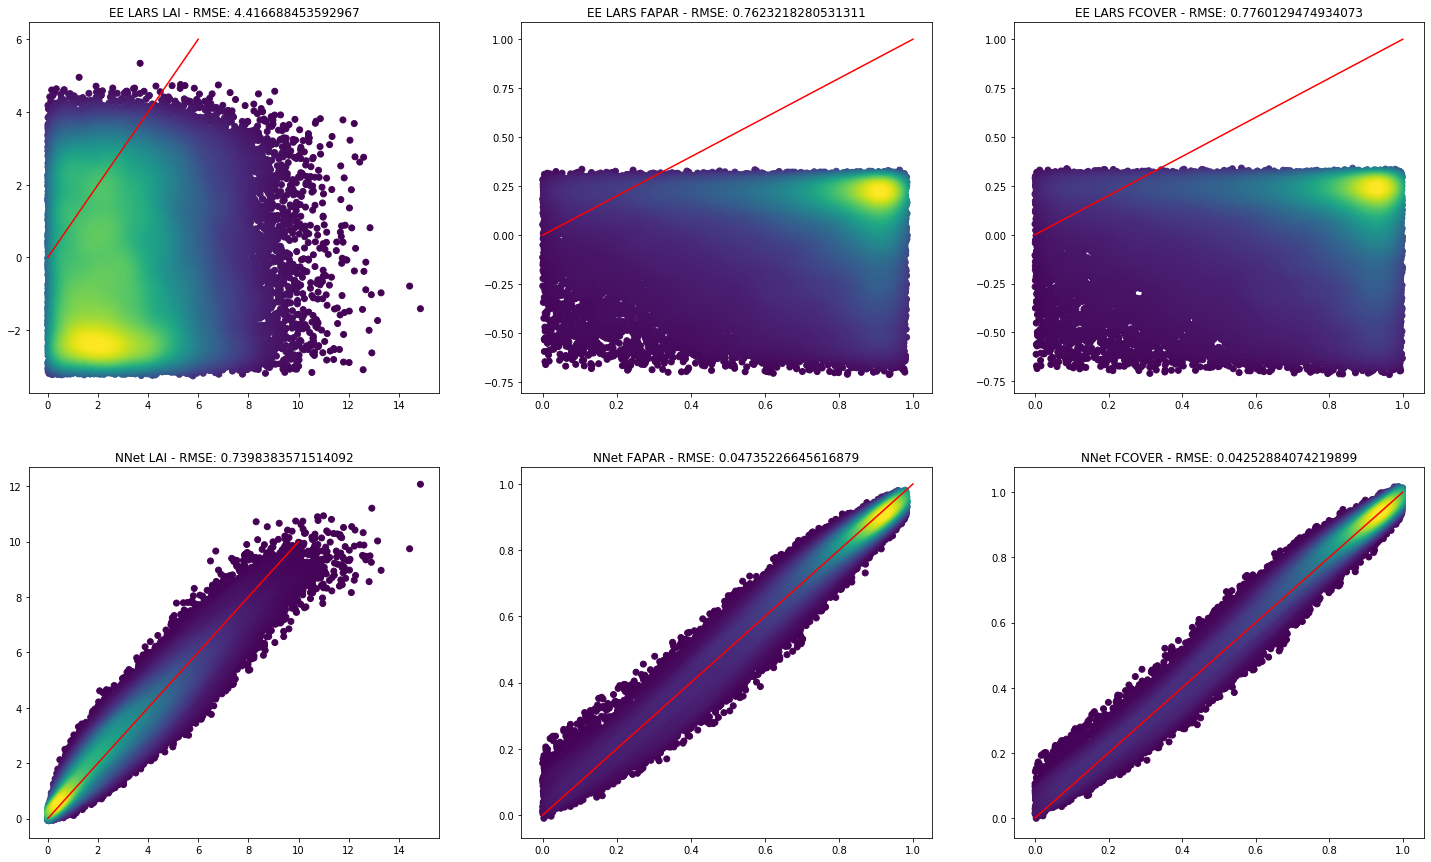

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(25,15))


ax[0,0].scatter(x_ee_LAI, y_ee_LAI, c=z_ee_LAI)
ax[0,0].plot(a_ee_LAI, a_ee_LAI, c='r')
ax[0,0].set_title('EE LARS LAI - RMSE: {}'.format(rmse_ee_LAI))


ax[0,1].scatter(x_ee_FAPAR, y_ee_FAPAR, c=z_ee_FAPAR)
ax[0,1].plot(a_ee_FAPAR, a_ee_FAPAR, c='r')
ax[0,1].set_title('EE LARS FAPAR - RMSE: {}'.format(rmse_ee_FAPAR))


ax[0,2].scatter(x_ee_FCOVER, y_ee_FCOVER, c=z_ee_FCOVER)
ax[0,2].plot(a_ee_FCOVER, a_ee_FCOVER, c='r')
ax[0,2].set_title('EE LARS FCOVER - RMSE: {}'.format(rmse_ee_FCOVER))


ax[1,0].scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax[1,0].plot(a_tf_LAI, a_tf_LAI, c='r')
ax[1,0].set_title('NNet LAI - RMSE: {}'.format(rmse_tf_LAI))


ax[1,1].scatter(x_tf_FAPAR, y_tf_FAPAR, c=z_tf_FAPAR)
ax[1,1].plot(a_tf_FAPAR, a_tf_FAPAR, c='r')
ax[1,1].set_title('NNet FAPAR - RMSE: {}'.format(rmse_tf_FAPAR))


ax[1,2].scatter(x_tf_FCOVER, y_tf_FCOVER, c=z_tf_FCOVER)
ax[1,2].plot(a_tf_FCOVER, a_tf_FCOVER, c='r')
ax[1,2].set_title('NNet FCOVER - RMSE: {}'.format(rmse_tf_FCOVER))